# LLaMA 3 8B Text Classification With QLoRA 

In [23]:
import pandas as pd
import numpy as np
import torch
import json
import wandb
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, DataCollatorWithPadding, Trainer
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
from datasets import Dataset, DatasetDict
import datetime
import torch.nn.functional as F

In [24]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

config = {
    "hidden_layer_sizes": [32, 64],
    "kernel_sizes": [3],
    "activation": "ReLU",
    "pool_sizes": [2],
    "dropout": 0.5,
    "num_classes": 10,
    "model_name": "bert-base-uncased"
}

run = wandb.init(
    project='wz_experimental',
    config=config
)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kawis\_netrc


In [25]:
id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [26]:
train = pd.read_csv('../datasets/quotes/quotes_train.csv')
test = pd.read_csv('../datasets/quotes/quotes_test.csv')
validation = train.sample(2091, random_state=42)
train = train.drop(validation.index)

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validation = validation.sample(frac=1).reset_index(drop=True)

In [27]:
train.head()

,text,label,level
0,a snake passion inside a man drive him for a ...,0,A1
1,remember that misuse of language can lead to m...,0,A1
2,to inquire into the intricacies of a distant l...,2,B1
3,some people have a large circle of friends whi...,0,A1
4,that which we persist in doing becomes easier ...,1,A2


In [28]:
test.head()

,text,label,level
0,majority rule gives the ruthless strong man pl...,3,B2
1,leave the comfort of your dark cocoon allow yo...,4,C1
2,addiction does not cause partner abuse and re...,4,C1
3,remember it doesnt matter what you can do wh...,0,A1
4,that is because no one could ever hate me as m...,0,A1


In [29]:
validation.head()

,text,label,level
0,i think that real friendship always makes us f...,1,A2
1,and that someone would pay revenge is a cold b...,1,A2
2,only it seems to me that once in your life bef...,0,A1
3,life rewards action to get from where you are ...,1,A2
4,any church that is overly emphasizing the role...,4,C1


In [30]:
print(train["text"].str.len().max())
print(test["text"].str.len().max())
print(validation["text"].str.len().max())

987
970
967


In [31]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train),
    'val': Dataset.from_pandas(validation),
    'test': Dataset.from_pandas(test)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 16130
    })
    val: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2091
    })
    test: Dataset({
        features: ['text', 'label', 'level'],
        num_rows: 2692
    })
})

In [32]:
class_weights=(1/train.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.0049, 0.0056, 0.0088, 0.0089, 0.0347, 0.9371])

In [33]:
model_name = "google-bert/bert-base-uncased"

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    device_map=None,
    resume_download=None,
    low_cpu_mem_usage=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    resume_download=None,
    add_prefix_space=True
)

In [36]:
model.config.use_cache = False
model.config.pretraining_tp = 1

In [37]:
MAX_LEN = 1000
col_to_delete = ['text']

def bert_preprocessing_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(bert_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/16130 [00:00<?, ? examples/s]

Map:   0%|          | 0/2091 [00:00<?, ? examples/s]

Map:   0%|          | 0/2692 [00:00<?, ? examples/s]

In [38]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [39]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}

In [40]:
class CustomTrainer(Trainer):
    def __init__(self, *arguments, c_weights=None, **kwargs):
        super().__init__(*arguments, **kwargs)
        
        if c_weights is not None:
            self.class_weights = torch.tensor(c_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, c_model, c_inputs, return_outputs=False):
        labels = c_inputs.pop("labels").long()

        outputs = c_model(**c_inputs)

        logits = outputs.get('logits')

        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [41]:
training_args = TrainingArguments(
    output_dir = 'model',
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs = 2,
    report_to="wandb",
    logging_dir='model',
    weight_decay = 0.01,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True
)

# training_arguments = TrainingArguments(
#     output_dir= 'model',
#     num_train_epochs=1,
#     per_device_train_batch_size=1,
#     gradient_accumulation_steps=8,
#     gradient_checkpointing=True,
#     optim="paged_adamw_32bit",
#     logging_steps=1,
#     learning_rate=2e-4,
#     weight_decay=0.001,
#     fp16=True,
#     bf16=False,
#     max_grad_norm=0.3,
#     max_steps=-1,
#     warmup_ratio=0.03,
#     group_by_length=False,
#     lr_scheduler_type="cosine",
#     report_to="wandb",
#     eval_steps = 0.2
# )


In [42]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'].shuffle(seed=42),
    eval_dataset = tokenized_datasets['val'].shuffle(seed=42),
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics
)

In [43]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Balanced Accuracy,Accuracy
1,0.675600,0.546275,0.727428,0.780966
2,0.369400,0.582092,0.761383,0.802487


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [44]:
model.config.use_cache = True

In [45]:
trainer.save_model('model')
tokenizer.save_pretrained('model')

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\vocab.txt',
 'model\\added_tokens.json',
 'model\\tokenizer.json')

In [46]:
def make_predictions(p_model, p_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    sentences = p_test.text.tolist()

    batch_size = 32 

    all_outputs = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]

        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)

        inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = p_model(**inputs)
            all_outputs.append(outputs['logits'])
            
    final_outputs = torch.cat(all_outputs, dim=0)
    p_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
    p_test['predictions']=p_test['predictions'].apply(lambda l:id_to_label_mapping[l])


make_predictions(model,test)

Started prediction at 2024-08-18 23:44:56.836129


Accuracy: 0.765
Accuracy for label A1: 0.884
Accuracy for label A2: 0.774
Accuracy for label B1: 0.572
Accuracy for label B2: 0.754
Accuracy for label C1: 0.690
Accuracy for label C2: 0.000

Classification Report:
              precision    recall  f1-score   support

          A1       0.88      0.88      0.88       853
          A2       0.73      0.77      0.75       753
          B1       0.63      0.57      0.60       442
          B2       0.74      0.75      0.75       492
          C1       0.71      0.69      0.70       142
          C2       0.00      0.00      0.00        10

    accuracy                           0.76      2692
   macro avg       0.62      0.61      0.61      2692
weighted avg       0.76      0.76      0.76      2692


Confusion Matrix:
[[754  99   0   0   0   0]
 [105 583  60   5   0   0]
 [  1 110 253  78   0   0]
 [  0   3  86 371  32   0]
 [  0   0   1  43  98   0]
 [  0   0   0   2   8   0]]


C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kawis\anaconda3\Lib\site-packag

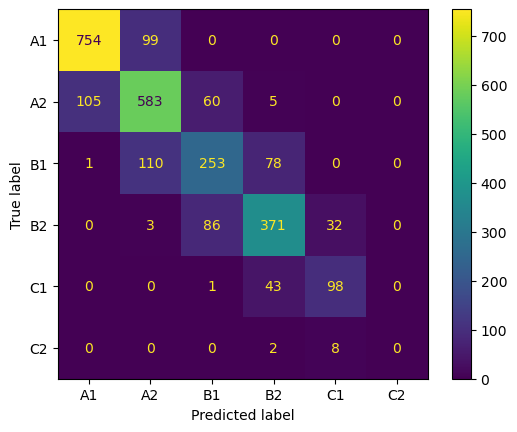

In [47]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = test['predictions']

y_true = test['level']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(train['level'], test['level'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [48]:
print(f'Ended prediction at {datetime.datetime.now()}')
wandb.finish()

Ended prediction at 2024-08-18 23:45:06.311576


eval/accuracy,▁█
eval/balanced_accuracy,▁█
eval/loss,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▂▃▄▄▅▆▇███
train/global_step,▁▂▃▄▄▅▆▇█████
train/grad_norm,▁▂▂▂▃█▄▁
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▆▅▄▂▂▁▁
